# Depresyon Durum Tahmini

**Ulanbek Toktogulov**

*ulanbek.toktogulov@gmail.com*

## **Problem tanımı ve amaç:** 

Veri seti, kontrol grubu hastalarının ve ‘condition’ grubu hastalarının verileri olmak üzere iki klasör içermektedir. Klasörler, her hasta için zaman içinde toplanan aktigraf verileri içeren ayrı bir csv dosyası içermektedir. Hastaların bu bilgilerine dayanarak depresyon durumunu otomatik olarak tahmin etmeyi amaçlamaktadır. Yapılacak bir app'te kişilerin karşısına çıkan sorulara verdiklere cevaplara bağlı olarak depresyon teşhisi koyulabilir.

In [10]:
import os
from datetime import datetime 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin

In [11]:
control_1 = pd.read_csv(r'data/control/control_1.csv')
condition_1 = pd.read_csv(r'data/condition/condition_1.csv')
print(f'control_1.shape: {control_1.shape}')
print(f'condition_1.shape: {condition_1.shape}')

control_1.shape: (51611, 3)
condition_1.shape: (23244, 3)


In [12]:
control_1.head()

,timestamp,date,activity
0,2003-03-18 15:00:00,2003-03-18,60
1,2003-03-18 15:01:00,2003-03-18,0
2,2003-03-18 15:02:00,2003-03-18,264
3,2003-03-18 15:03:00,2003-03-18,662
4,2003-03-18 15:04:00,2003-03-18,293


In [13]:
condition_1.head()

,timestamp,date,activity
0,2003-05-07 12:00:00,2003-05-07,0
1,2003-05-07 12:01:00,2003-05-07,143
2,2003-05-07 12:02:00,2003-05-07,0
3,2003-05-07 12:03:00,2003-05-07,20
4,2003-05-07 12:04:00,2003-05-07,166


In [14]:
condition_1.describe()

,activity
count,23244.000000
mean,146.948030
std,294.592424
min,0.000000
25%,0.000000
50%,9.000000
75%,172.000000
max,3526.000000


<AxesSubplot:xlabel='activity', ylabel='Count'>

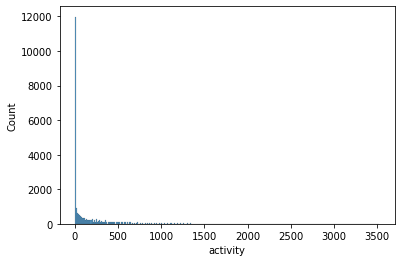

In [15]:
sns.histplot(x='activity', data=condition_1)

In [16]:
condition_1['activity'].skew()

3.8823677090908344

In [17]:
condition_1['log_activity'] = np.log(condition_1['activity'] + 1) # +1 ekleriz cunku log(0) sonsuzluga gider
condition_1['log_activity'].skew()

0.2771381485812395

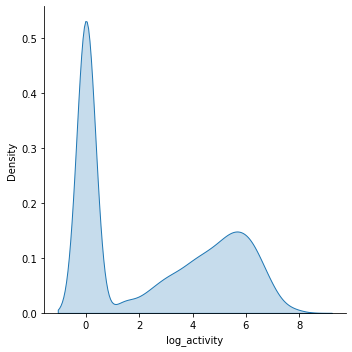

In [18]:
sns.displot(x='log_activity', data=condition_1, kind='kde', fill=True)

In [20]:
condition_1.describe()

,activity,log_activity
count,23244.000000,23244.000000
mean,146.948030,2.562035
std,294.592424,2.626393
min,0.000000,0.000000
25%,0.000000,0.000000
50%,9.000000,2.302585
75%,172.000000,5.153292
max,3526.000000,8.168203


In [21]:
condition_1['sqrt_activity'] = np.sqrt(condition_1['activity'])
condition_1['sqrt_activity'].skew()

1.370447546298057

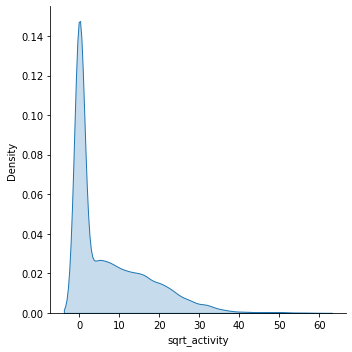

In [22]:
sns.displot(x='sqrt_activity', data=condition_1, kind='kde', fill=True)

In [23]:
condition_1.describe()

,activity,log_activity,sqrt_activity
count,23244.000000,23244.000000,23244.000000
mean,146.948030,2.562035,7.416512
std,294.592424,2.626393,9.588917
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,9.000000,2.302585,3.000000
75%,172.000000,5.153292,13.114877
max,3526.000000,8.168203,59.380131


In [24]:
control_1['activity'].skew()

5.039169993104665

In [25]:
control_1.describe()

,activity
count,51611.000000
mean,98.545078
std,289.655317
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,6117.000000


In [26]:
control_1['log_activity'] = np.log(control_1['activity'] + 1)
control_1['log_activity'].skew()

1.2517081703386566

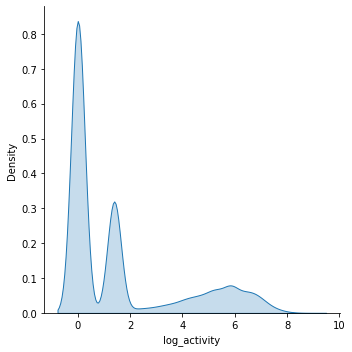

In [27]:
sns.displot(x='log_activity', data=control_1, kind='kde', fill=True)

In [28]:
condition_1.head()

,timestamp,date,activity,log_activity,sqrt_activity
0,2003-05-07 12:00:00,2003-05-07,0,0.000000,0.000000
1,2003-05-07 12:01:00,2003-05-07,143,4.969813,11.958261
2,2003-05-07 12:02:00,2003-05-07,0,0.000000,0.000000
3,2003-05-07 12:03:00,2003-05-07,20,3.044522,4.472136
4,2003-05-07 12:04:00,2003-05-07,166,5.117994,12.884099


In [29]:
df = condition_1.groupby('date')['log_activity'].mean().reset_index()
df.head()

,date,log_activity
0,2003-05-07,3.752204
1,2003-05-08,2.931977
2,2003-05-09,2.593095
3,2003-05-10,2.910573
4,2003-05-11,2.561446


In [30]:
def combine_data(path):
    dirs = os.listdir(path)
    combine_df = []
    
    for filepath in dirs:
        source = filepath.split('.')[0]
        if filepath.endswith('.csv'):
            X = pd.read_csv(path + filepath, parse_dates=['timestamp'], index_col='timestamp')
            X['source'] = source
            combine_df.append(X)
        
    return combine_df

In [31]:
combine_df = combine_data(r'data/condition/')

In [32]:
conditions = []
for condition in combine_df:
    condition_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source'])
    condition_df['mean_activity'] = condition.activity.resample('H').mean()
    condition_df['std_activity'] = condition.activity.resample('H').std()
    condition_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in condition.activity.resample('H')]
    condition_df['source'] = condition.source
    conditions.append(condition_df)

In [33]:
combine_df = combine_data(r'data/control/')

In [34]:
controls = []
for control in combine_df:
    control_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source'])
    control_df['mean_activity'] = control.activity.resample('H').mean()
    control_df['std_activity'] = control.activity.resample('H').std()
    control_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in control.activity.resample('H')]
    control_df['source'] = control.source
    controls.append(control_df)

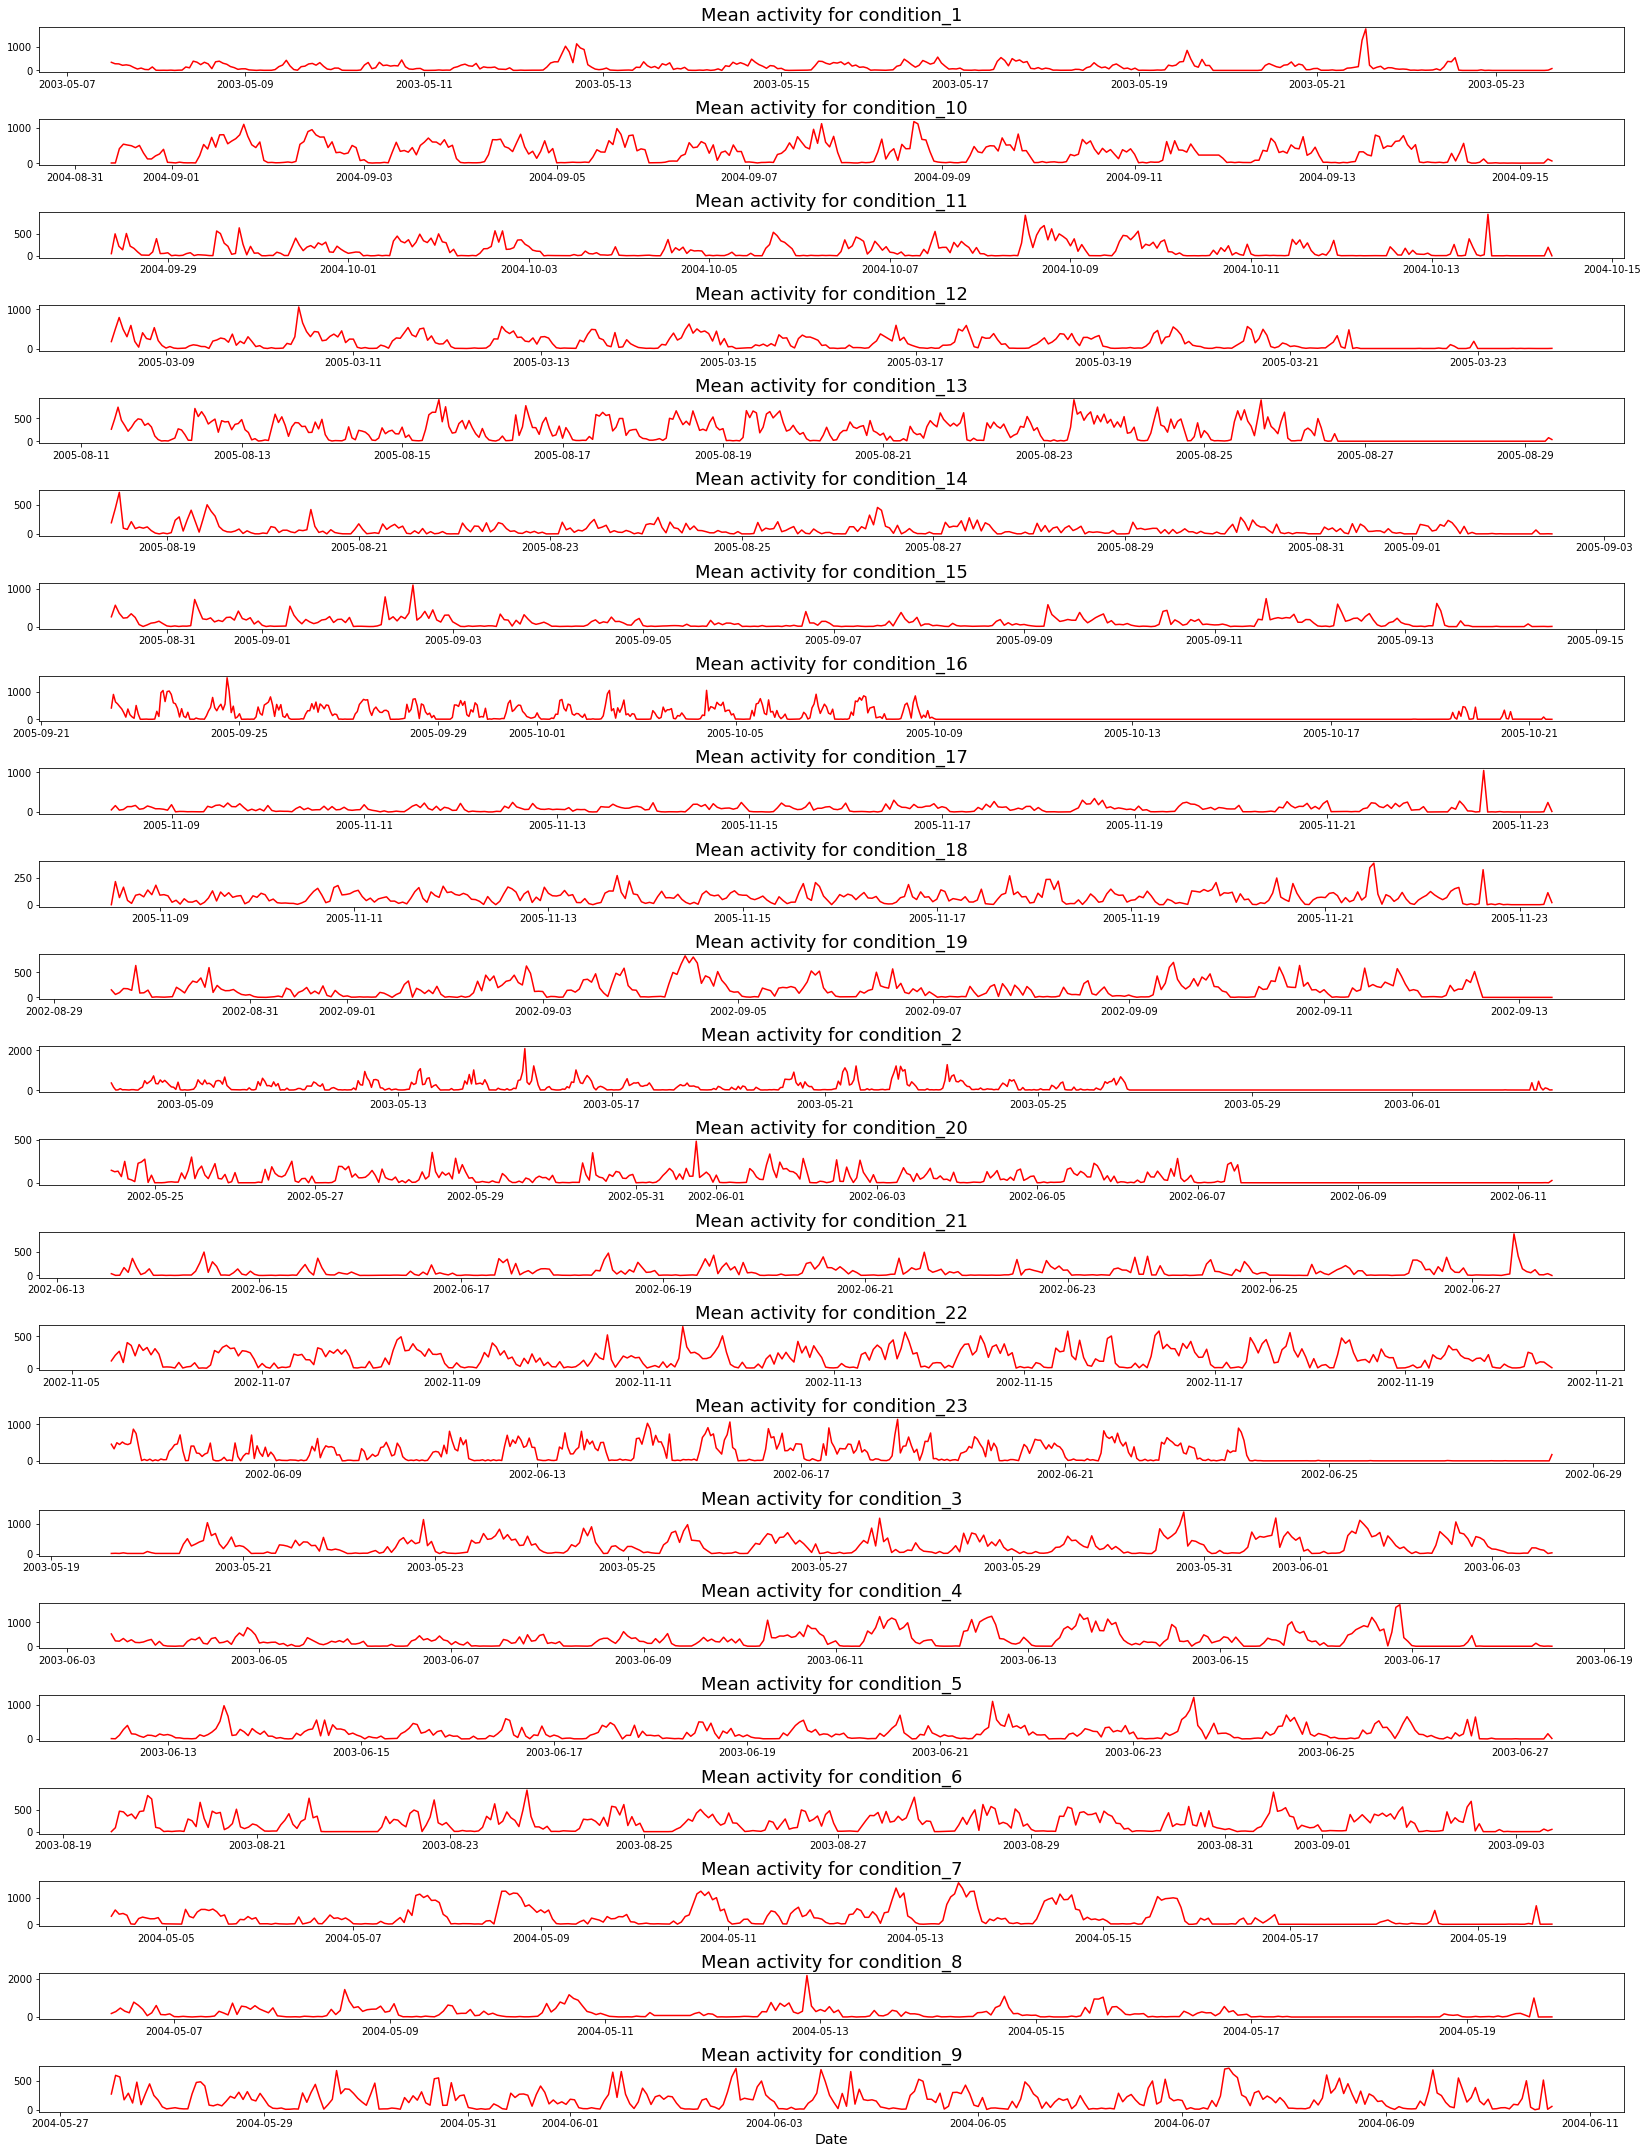

In [35]:
fig, axes = plt.subplots(23, 1, figsize=(23, 30))
cnt = 0
for i in range(23):
    condition = conditions[cnt]
    axes[i].plot(condition.index, condition.mean_activity, color='r')
    axes[i].set_title(f'Mean activity for {condition.source[1]}', fontsize=18)
    cnt += 1
    
plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
fig.savefig('Mean activity of condition group.jpg', dpi=100)
plt.show()

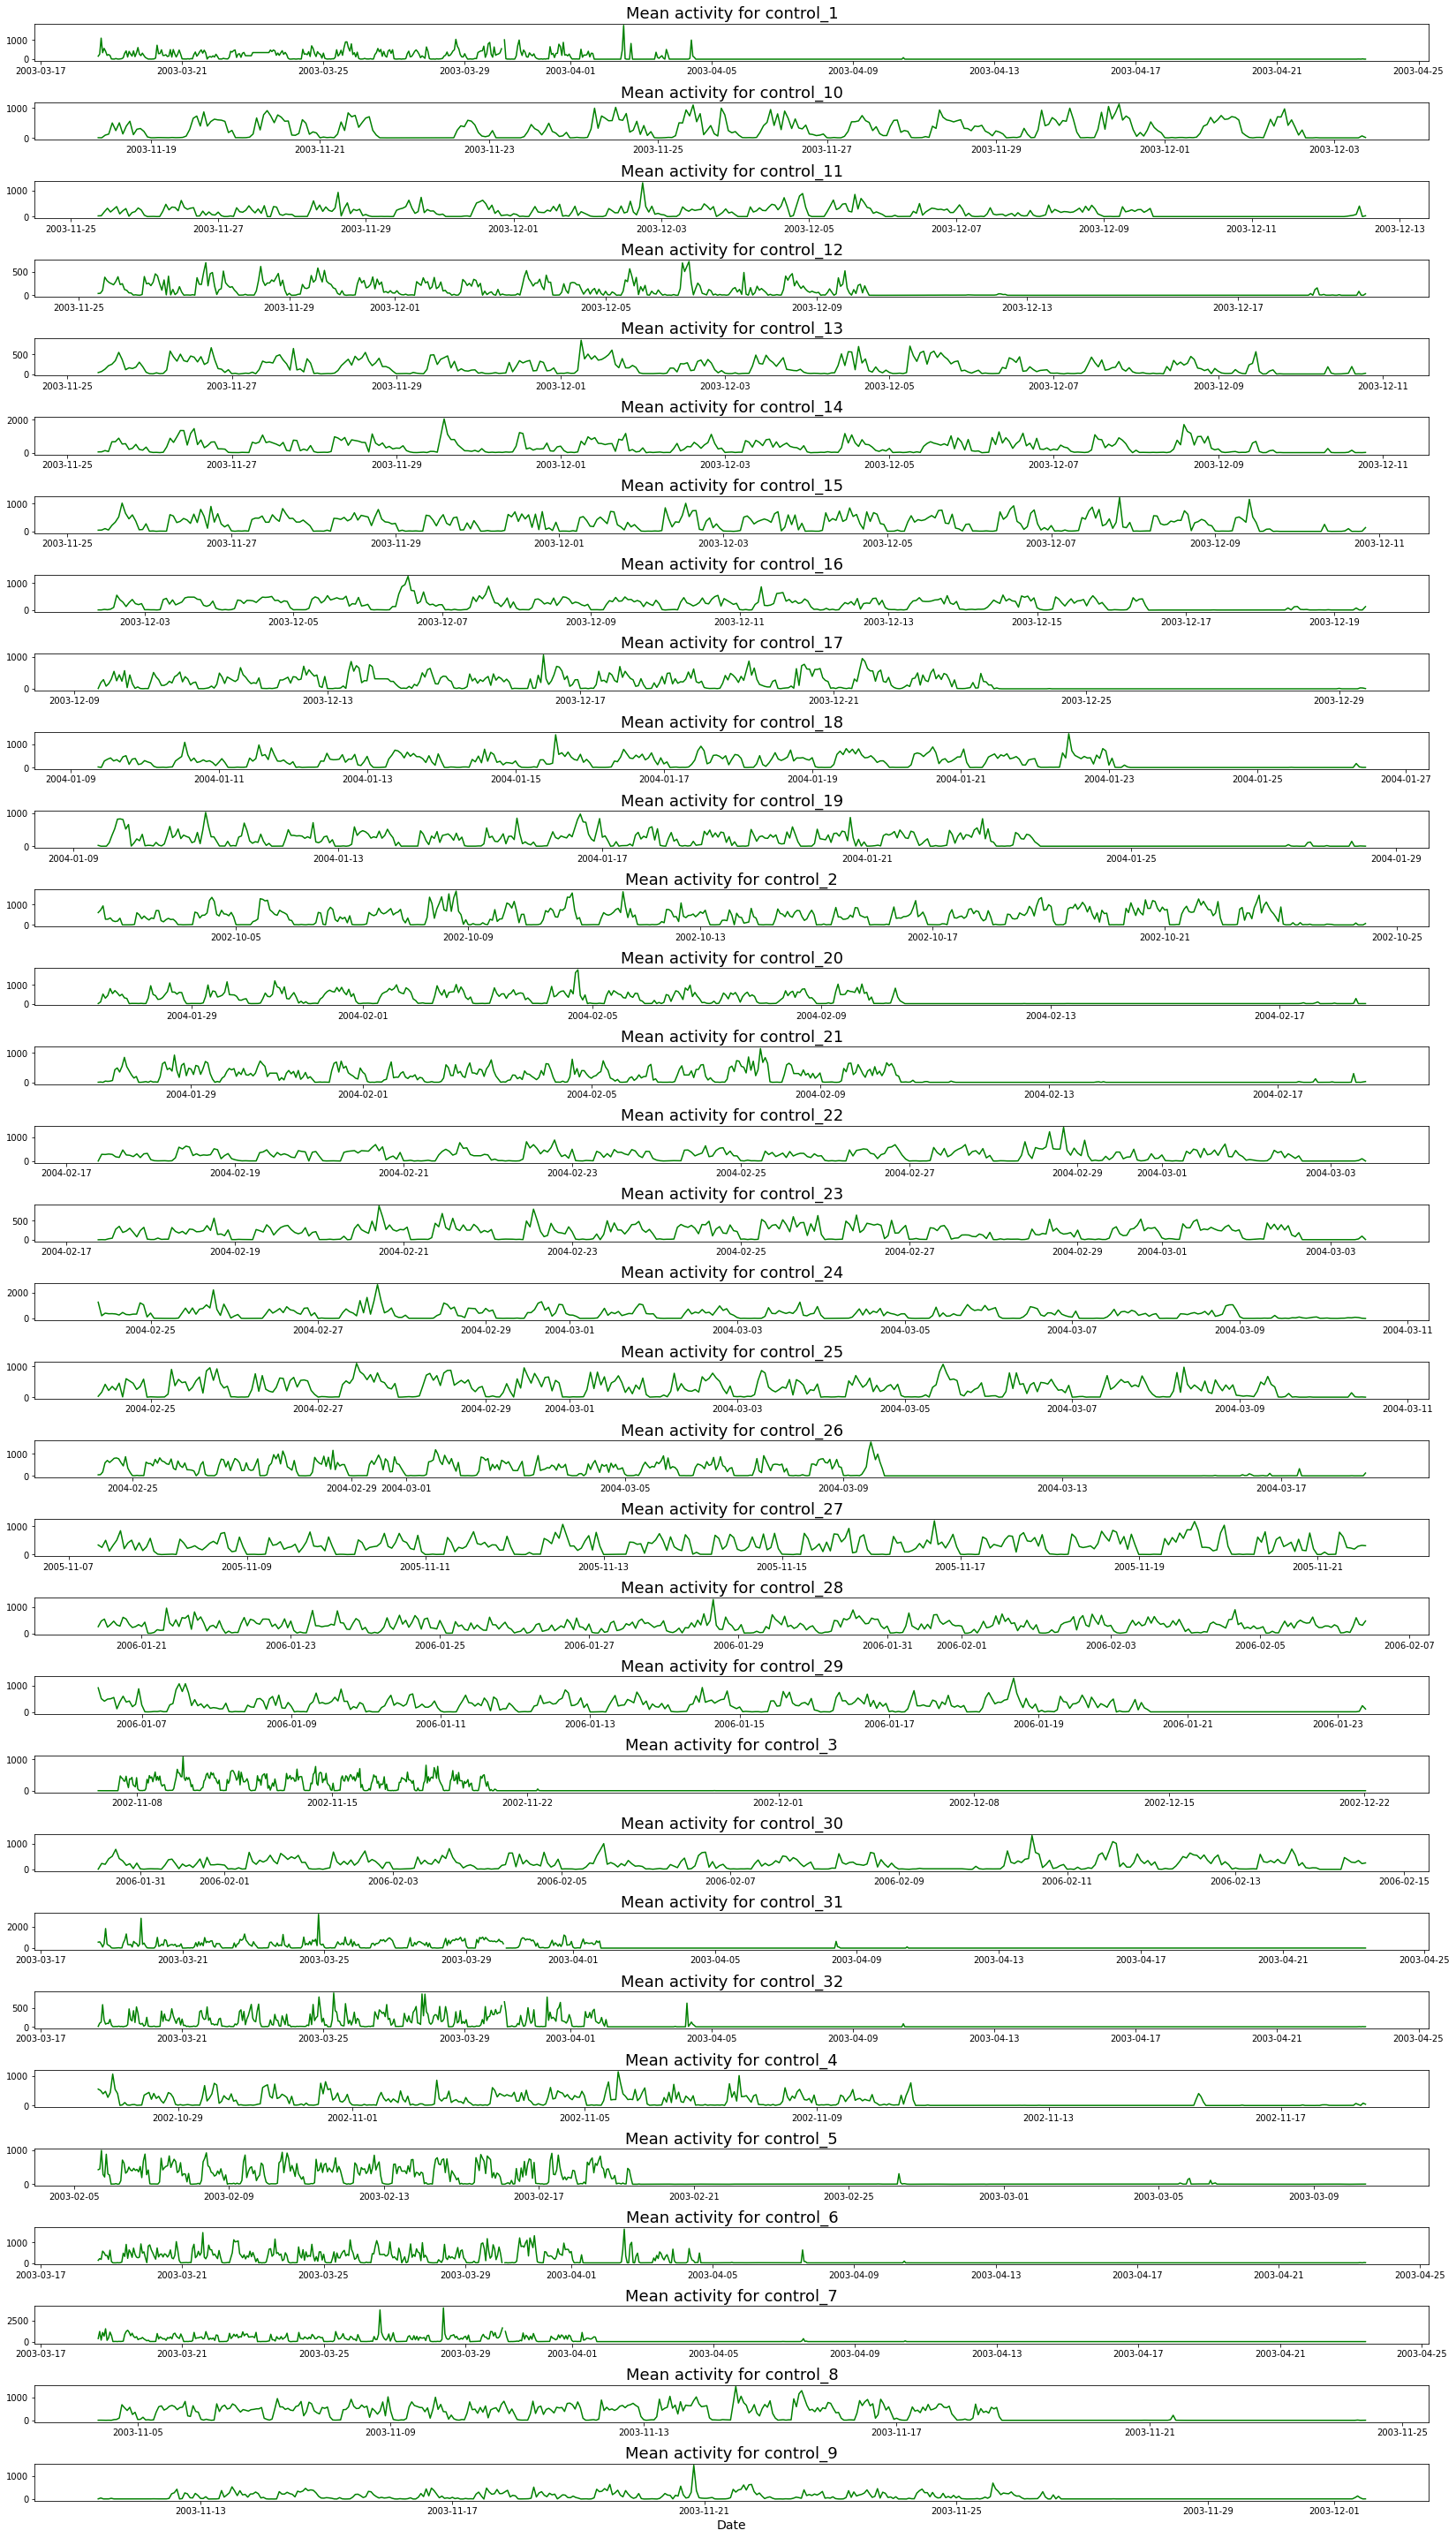

In [36]:
fig, axes = plt.subplots(32, 1, figsize=(23, 40))
cnt = 0
for i in range(32):
    control = controls[cnt]
    axes[i].plot(control.index, control.mean_activity, color='g')
    axes[i].set_title(f'Mean activity for {control.source[1]}', fontsize=18)
    cnt += 1
    
plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
fig.savefig('Mean activity of control group.jpg', dpi=100)
plt.show()

In [37]:
def to_clock(x):
    d = datetime.strptime(f'{x}:00', '%H:%M')
    return d.strftime('%I:%M %p')

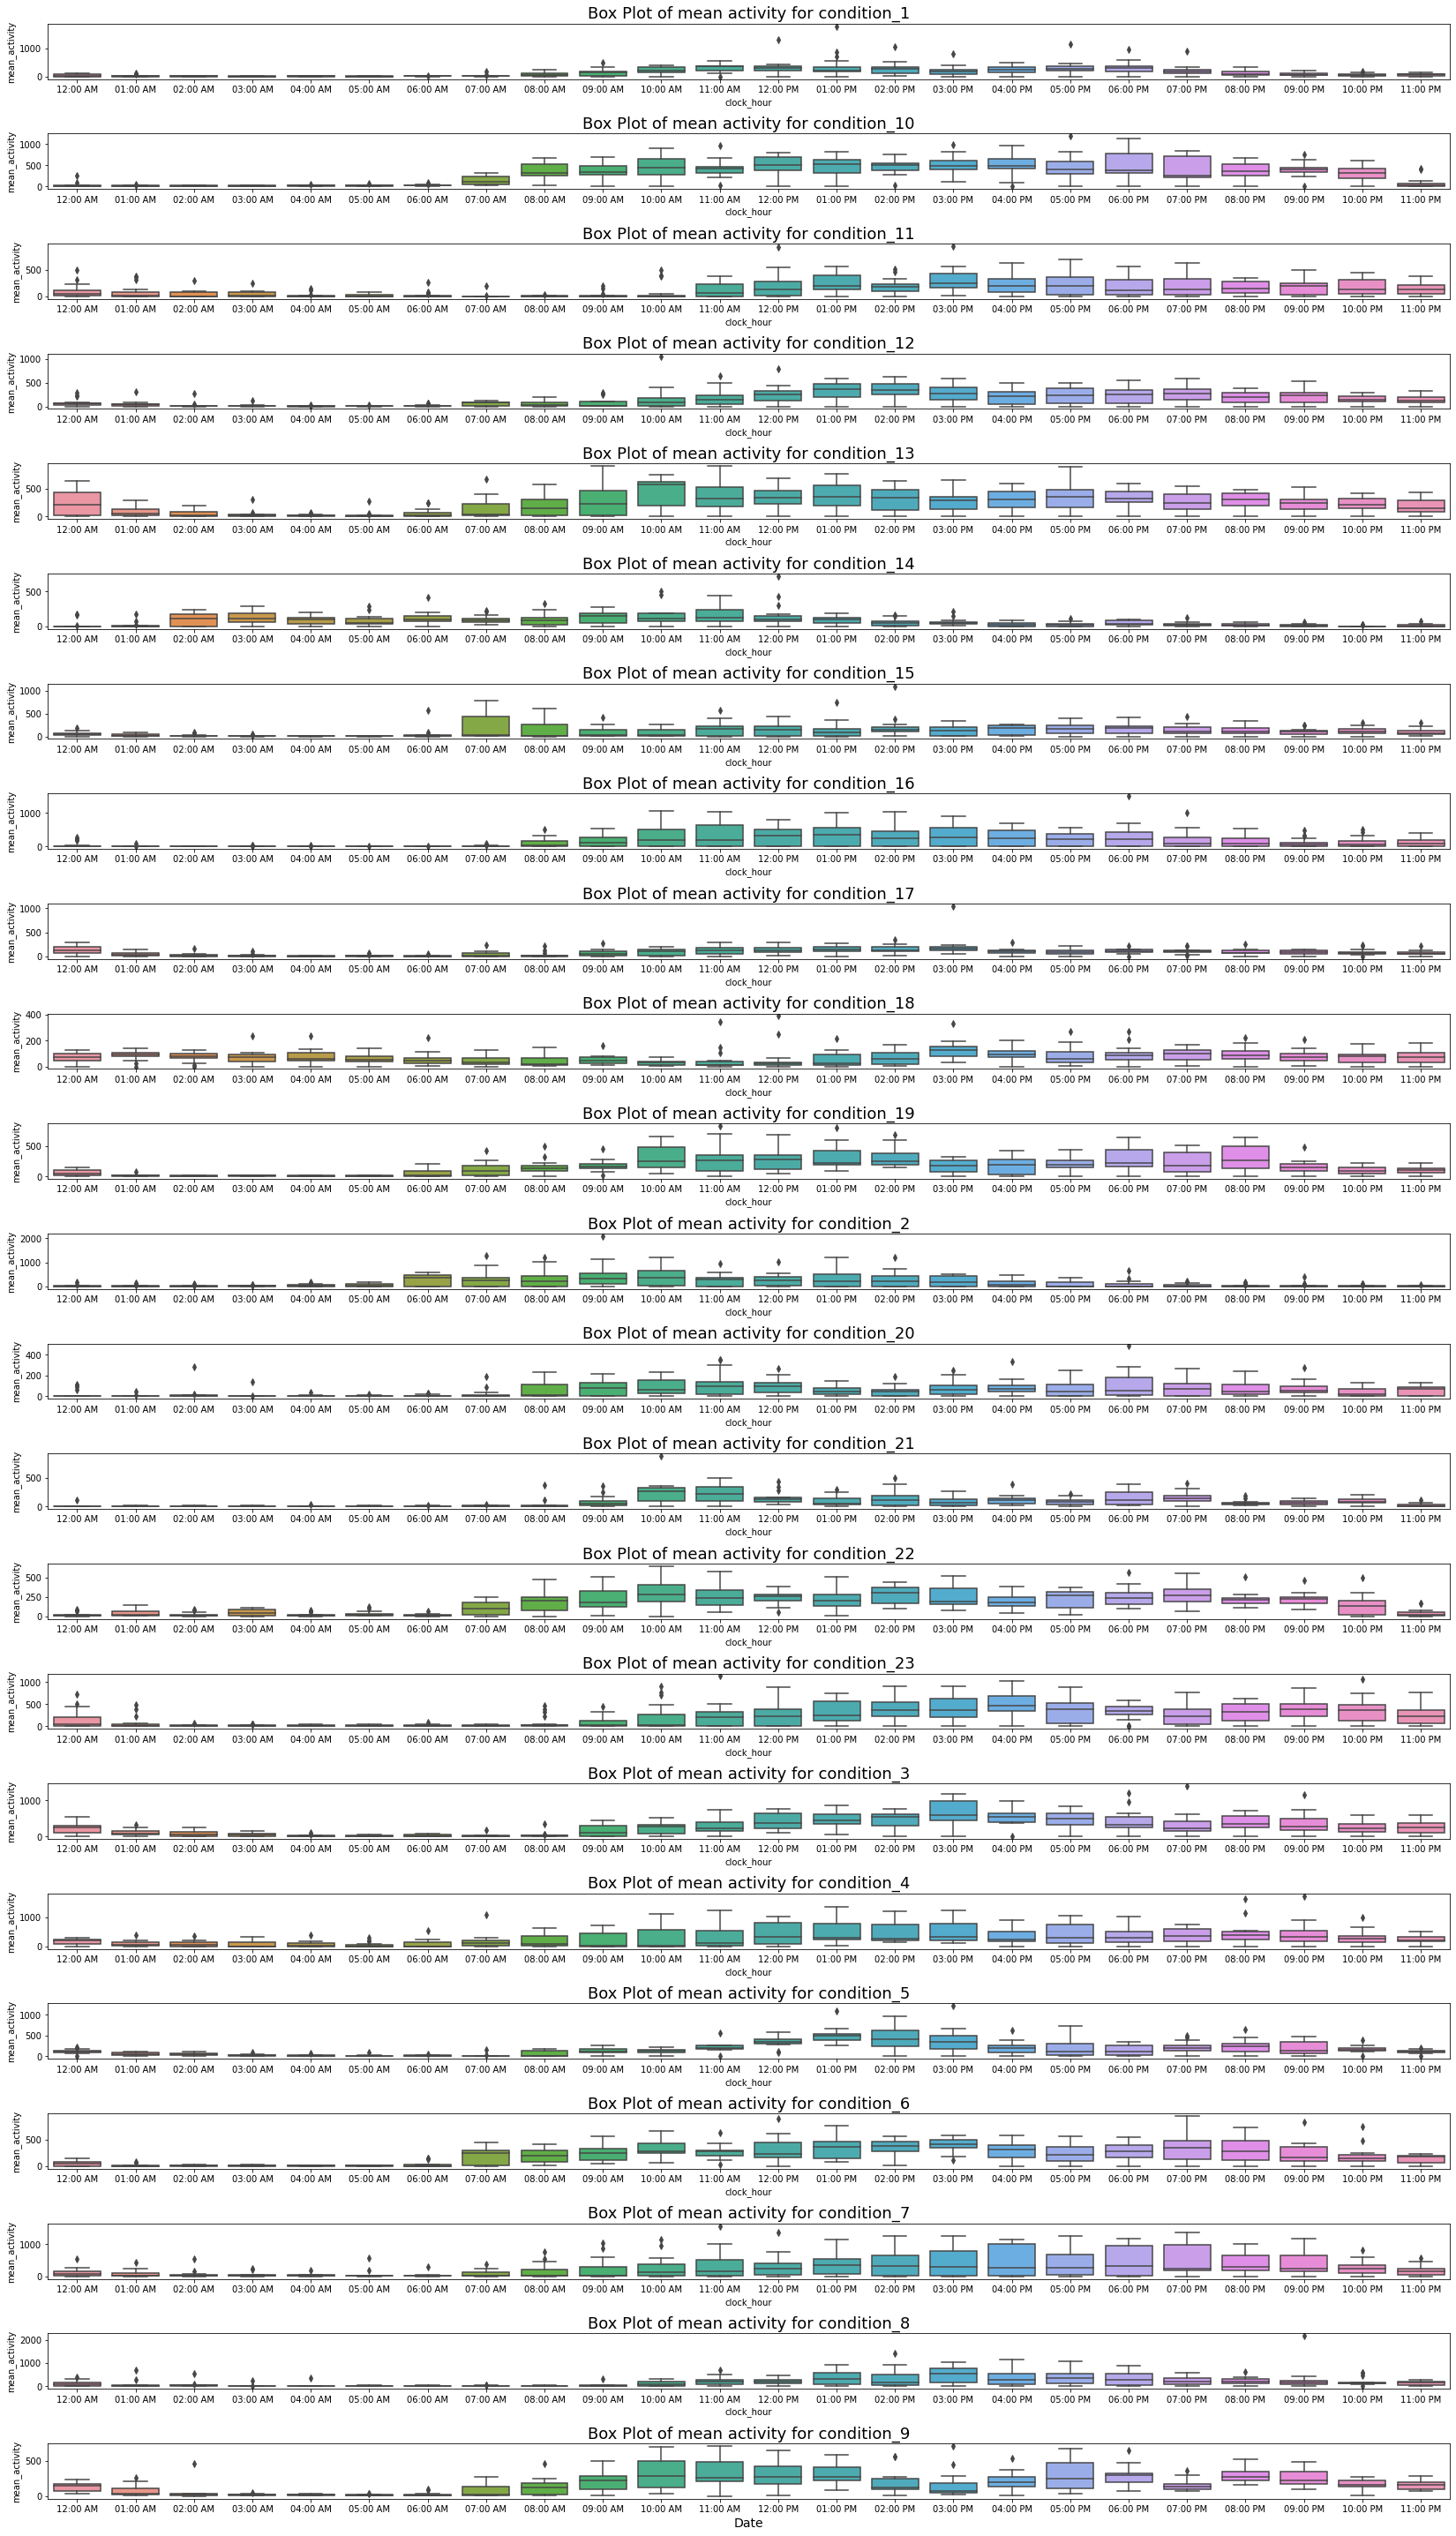

In [38]:
fig, axes = plt.subplots(23, 1, figsize=(23, 40))

cnt = 0
for i in range(23):
    df = conditions[i].reset_index()

    # Prepare data
    df['hour'] = [d.hour for d in df.timestamp]
    df = df.sort_values('hour')
    df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
    sns.boxplot(x='clock_hour', y='mean_activity', data=df, ax=axes[i])
    axes[i].set_title(f'Box Plot of mean activity for {df.source[1]}', fontsize=18)
    cnt += 1

plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
plt.show()

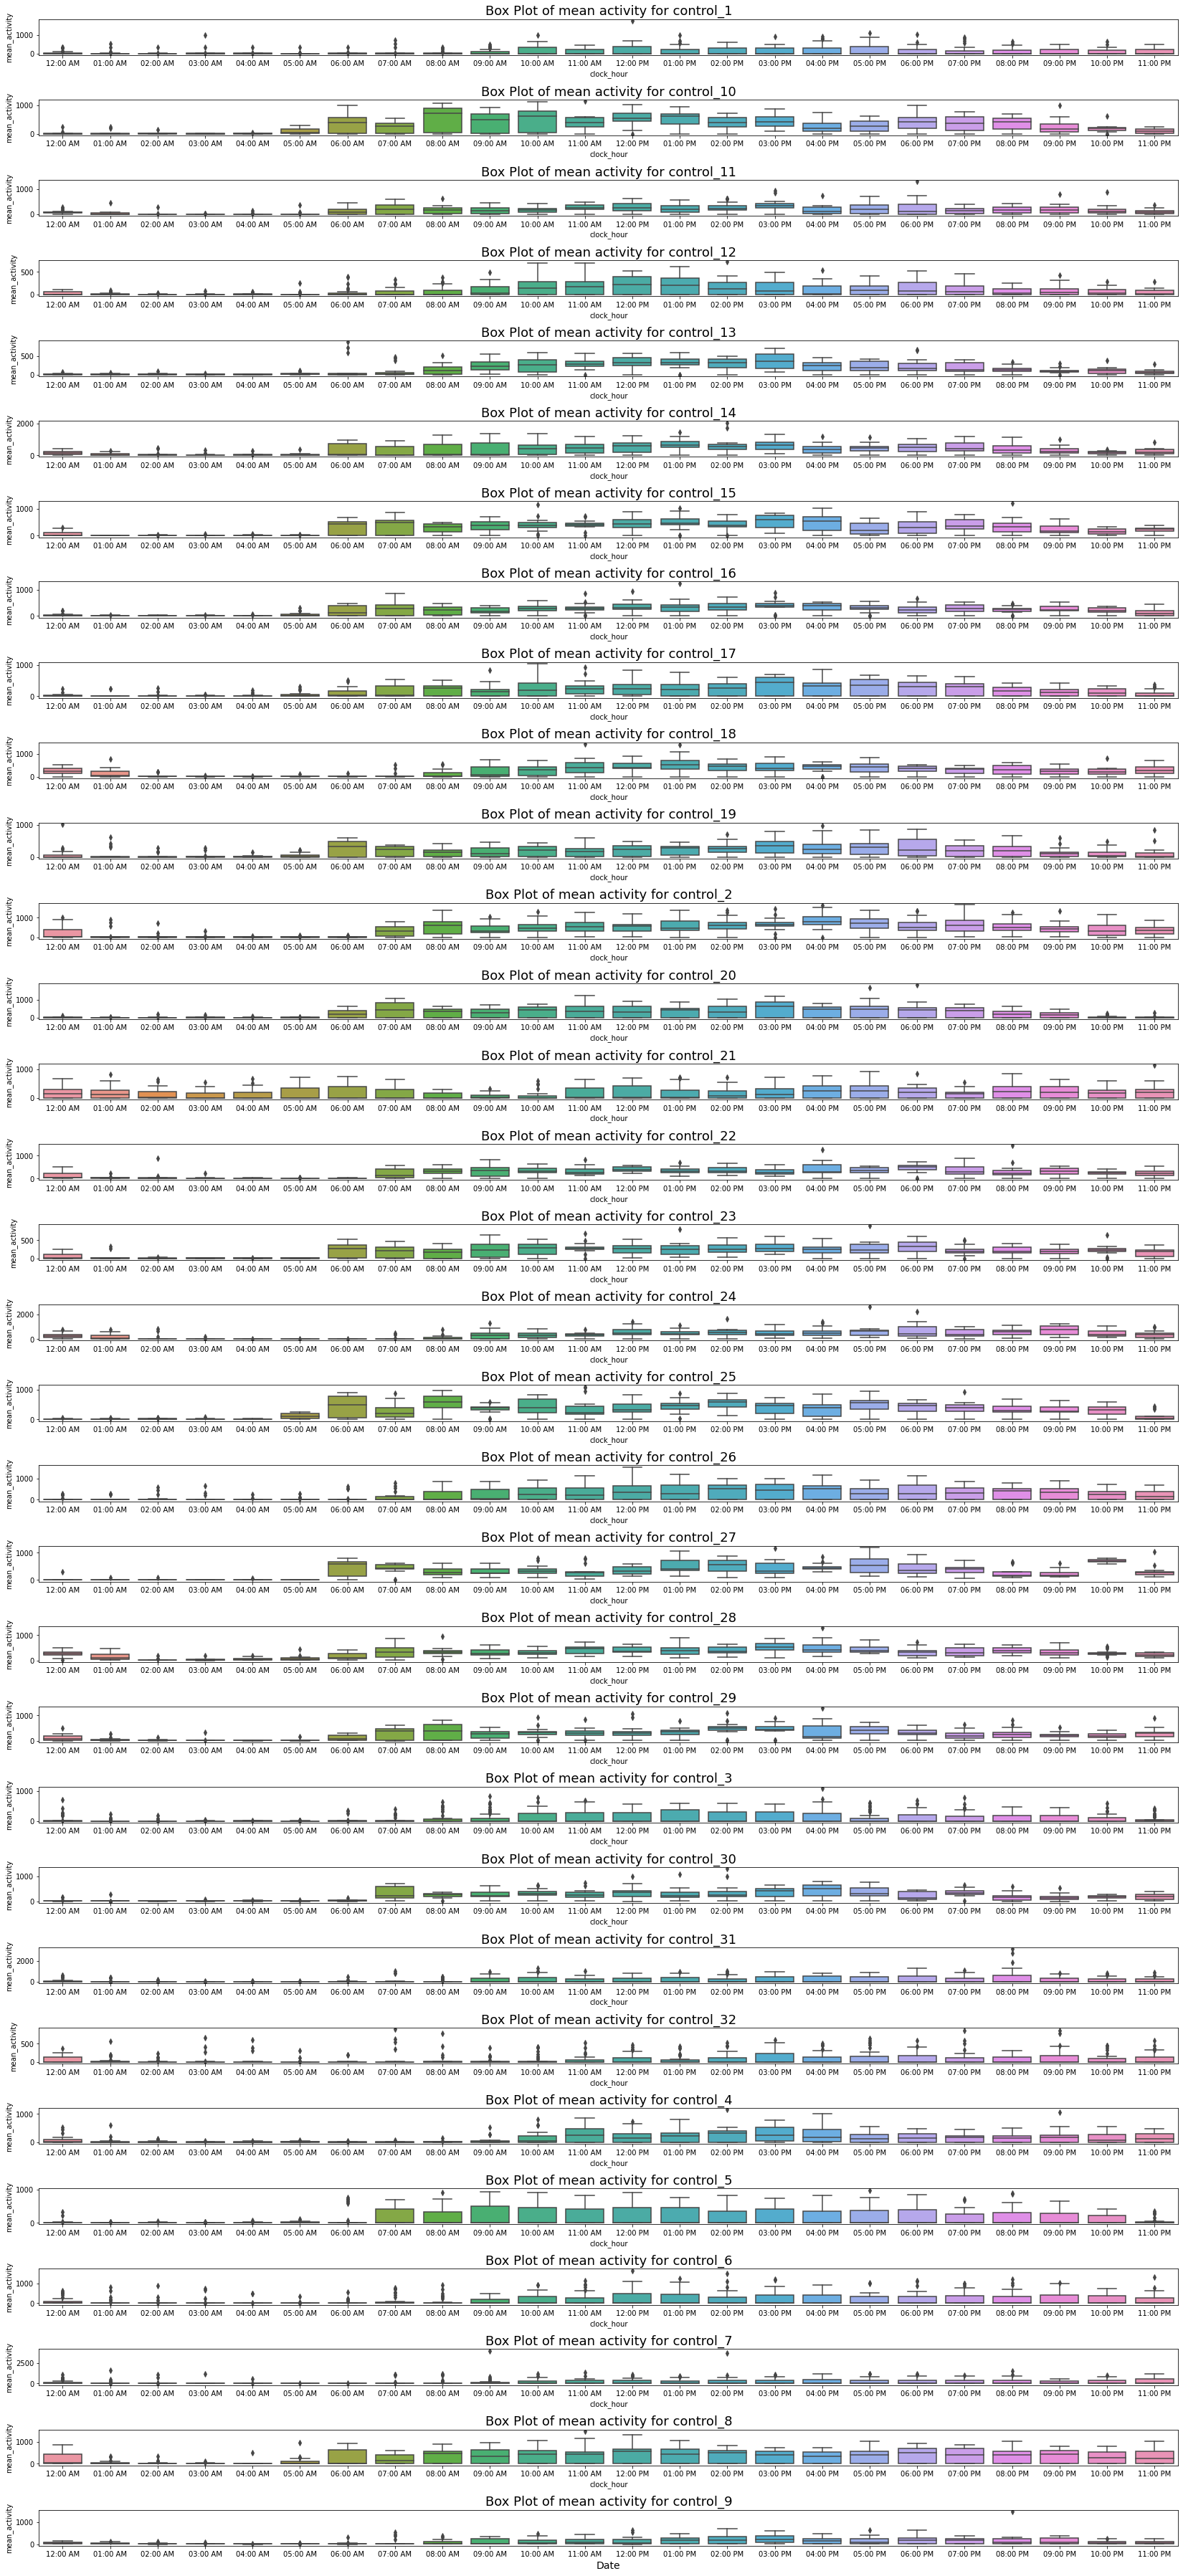

In [39]:
fig, axes = plt.subplots(32, 1, figsize=(23, 50))

cnt = 0
for i in range(32):
    df = controls[i].reset_index()

    # Prepare data
    df['hour'] = [d.hour for d in df.timestamp]
    df = df.sort_values('hour')
    df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
    sns.boxplot(x='clock_hour', y='mean_activity', data=df, ax=axes[i])
    axes[i].set_title(f'Box Plot of mean activity for {df.source[1]}', fontsize=18)
    cnt += 1

plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
plt.show()

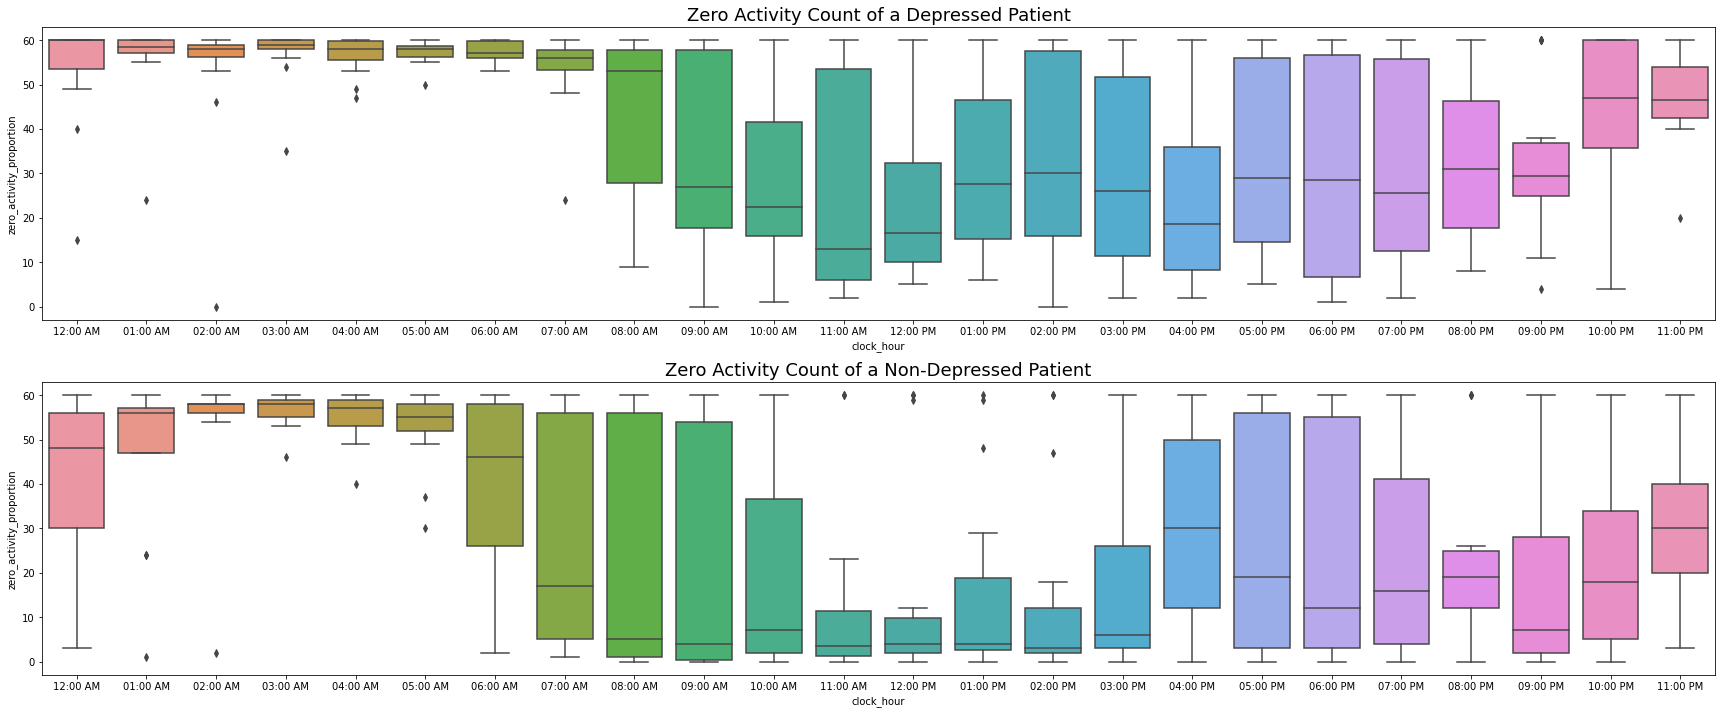

In [40]:
fig, axes = plt.subplots(2, 1, figsize=(24, 10))
df = conditions[12].reset_index()
df['hour'] = [d.hour for d in df.timestamp]
df = df.sort_values('hour')
df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
sns.boxplot(x='clock_hour', y='zero_activity_proportion', data=df, ax=axes[0])
axes[0].set_title('Zero Activity Count of a Depressed Patient', fontsize=18)

df = controls[2].reset_index()
df['hour'] = [d.hour for d in df.timestamp]
df = df.sort_values('hour')
df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
sns.boxplot(x='clock_hour', y='zero_activity_proportion', data=df, ax=axes[1])
axes[1].set_title('Zero Activity Count of a Non-Depressed Patient', fontsize=18)

fig.tight_layout(pad=1.0)
plt.show()

In [41]:
def nextday(dates):
    for date in dates:
        yield date

In [42]:
def zero_count(series):
    return list(series).count(0)

In [43]:
def extractfeatures(X, date):
    mask = X['date'] == date
    d = {
        'mean_log_activity': X[mask]['log_activity'].mean(),
        'std_log_activity': X[mask]['log_activity'].std(),
        'min_log_activity': X[mask]['log_activity'].min(),
        'max_log_activity': X[mask]['log_activity'].max(),
        'zero_proportion_activity': zero_count(X[mask]['log_activity'])
    }
    return d

In [44]:
class ExtractData(BaseEstimator, TransformerMixin):
    
    def __init__(self, path):
        self.path = path
        self.X = []

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        dirs = os.listdir(self.path)
        
        for filepath in sorted(dirs, key=lambda x: x.split('_')[0]):
            condition = filepath.split('.')[0]
            if filepath.endswith('.csv'):
                X = pd.read_csv(self.path + filepath)
                X['log_activity'] = np.log(X['activity'] + 1)
                dates = X.date.unique()
                
                for date in nextday(dates):
                    d = extractfeatures(X, date)
                    d['source'] = condition
                    self.X.append(d)
                

        return pd.DataFrame(self.X)

In [46]:
e = ExtractData(path='data/condition/')
conditions = e.fit_transform(X=None, y=None)
conditions['state'] = 1

In [47]:
conditions.tail()


,mean_log_activity,std_log_activity,min_log_activity,max_log_activity,zero_proportion_activity,source,state
400,2.836361,2.604526,0.0,7.789869,578,condition_9,1
401,3.317860,2.664783,0.0,7.945201,491,condition_9,1
402,3.174113,2.653188,0.0,7.664816,505,condition_9,1
403,2.860525,2.617277,0.0,7.696213,572,condition_9,1
404,1.648750,2.476757,0.0,7.602900,596,condition_9,1


In [48]:
e = ExtractData(path='data/control/')
controls = e.fit_transform(X=None, y=None)
controls['state'] = 0

In [49]:
full_df = controls.append(conditions, ignore_index=True)
full_df.head()

,mean_log_activity,std_log_activity,min_log_activity,max_log_activity,zero_proportion_activity,source,state
0,4.269175,2.536873,0.0,7.758761,106,control_1,0
1,3.006935,2.636401,0.0,8.038512,557,control_1,0
2,3.220895,2.683718,0.0,7.883069,516,control_1,0
3,2.737783,2.699849,0.0,7.633854,657,control_1,0
4,3.302284,2.641430,0.0,7.789869,520,control_1,0


In [50]:
full_df.shape

(1144, 7)

In [51]:
full_df = full_df.sample(frac=1)

In [52]:
def custom_train_test_split(train_set, test_set):
    X_train = train_set.drop('label', axis=1)
    y_train = train_set.label
    X_test = test_set.drop('label', axis=1)
    y_test = test_set.label
    
    return X_train, X_test, y_train, y_test

In [53]:
class CustomClassifierCV(BaseEstimator, TransformerMixin):
    
    def __init__(self, base_clf):
        self.base_clf = base_clf
    
    def fit(self, X, y=None):
        X['label'] = y
        participants = X.source.unique()
        folds = []
        
        predictions = [] # predicted labels
        actuals = [] # actual labels
            
        for p in participants:
            folds.append(X[X['source'] == p])
        
        for i in range(len(folds)):   
            test_set = folds[i]
            train_fold = [elem for idx , elem in enumerate(folds) if idx != i]
            
            train_set = pd.concat(train_fold)
            X_train, X_test, y_train, y_test = custom_train_test_split(train_set.drop(['source'], axis=1),
                                    test_set.drop(['source'], axis=1))
            
            self.base_clf.fit(X_train, y_train)
            predictions.append(self.predict(X_test))
            actuals.append(test_set.label.iloc[0])
            
        self.score(predictions, actuals)
        
    def predict(self, X):
        predictions = self.base_clf.predict(X)
        ones = predictions.tolist().count(1)
        zeroes = predictions.tolist().count(0)
        
        return 1 if ones > zeroes else 0
    
    def score(self, predictions, actuals):
        print(classification_report(predictions, actuals))

In [54]:
X = full_df.drop(['state'], axis=1)
y = full_df.state

In [ ]:
forest = RandomForestClassifier(n_estimators=100)
custom_clfCV = CustomClassifierCV(forest)
custom_clfCV.fit(X, y)